In [127]:
# import relevant python libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
# import sales evaluation file 
df1 = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
df1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [3]:
df1.shape

(30490, 1947)

In [4]:
# sum the total sales per item and put them in ascending order
# df1.sum(axis=1).sort_values(ascending = False)

In [5]:
# sum the total sales per group of items
df1.groupby('dept_id').sum()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
dept_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,...,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,...,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,...,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,...,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
HOBBIES_2,154,185,185,138,100,87,89,155,158,101,...,449,479,552,419,487,449,448,382,501,560
HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,2857,...,7936,10042,10572,7609,6999,6641,6759,7974,9668,10165
HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,1199,...,2159,2797,2886,2067,2001,1925,1992,2299,2918,2926


Let's take FOODS_3 as our group of items as it has the most sales and will provide more straight forward modelling: 

In [6]:
df2 = df1[df1.dept_id == 'FOODS_3']
df2.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001_CA_1_evaluation,FOODS_3_001,FOODS_3,FOODS,CA_1,CA,1,1,1,1,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002_CA_1_evaluation,FOODS_3_002,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003_CA_1_evaluation,FOODS_3_003,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004_CA_1_evaluation,FOODS_3_004,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005_CA_1_evaluation,FOODS_3_005,FOODS_3,FOODS,CA_1,CA,1,0,1,2,...,1,2,0,0,0,0,0,1,0,1


In [7]:
df2.shape

(8230, 1947)

In [8]:
# Check if the number of rows in df2 matches the count for FOODS_3 in df1
df1.groupby('dept_id')['dept_id'].agg('count')

dept_id
FOODS_1        2160
FOODS_2        3980
FOODS_3        8230
HOBBIES_1      4160
HOBBIES_2      1490
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
Name: dept_id, dtype: int64

In [9]:
# Drop unnecessary columns 
df3 = df2.drop(['id', 'dept_id', 'cat_id', 'state_id'], axis = 'columns')
df3.head()

,item_id,store_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001,CA_1,1,1,1,1,1,0,1,2,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002,CA_1,0,0,0,0,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003,CA_1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004,CA_1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005,CA_1,1,0,1,2,2,0,1,1,...,1,2,0,0,0,0,0,1,0,1


In [10]:
len(df3.item_id.unique())

823

In [11]:
#Aggregate the items from all the Walmart stores as singular total sales per item
df4 = df3.groupby('item_id').sum()
df4.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001,7,8,7,13,5,8,10,19,14,9,...,4,7,11,4,5,8,11,9,12,13
FOODS_3_002,0,0,0,0,0,0,0,0,0,0,...,33,41,42,41,35,19,23,23,35,26
FOODS_3_003,0,0,0,0,0,0,0,0,0,0,...,11,7,13,10,3,5,7,7,3,6
FOODS_3_004,0,0,0,0,0,0,0,0,0,0,...,3,7,2,1,3,5,4,6,6,2
FOODS_3_005,4,9,3,10,7,12,6,9,12,6,...,7,11,11,11,6,8,13,16,6,16


In [12]:
df4.shape

(823, 1941)

In [13]:
# Get total sales per day for FOODS_3 items 
df5 = pd.DataFrame()
df5['FOODS_3'] = df4.sum()
df5.head()

,FOODS_3
d_1,16741
d_2,16333
d_3,12343
d_4,13764
d_5,10525


In [14]:
# set the date column as "d"
df6 = df5.reset_index()
df7 = df6.rename(columns={'index':'d'})
df7.head()

,d,FOODS_3
0,d_1,16741
1,d_2,16333
2,d_3,12343
3,d_4,13764
4,d_5,10525


In [15]:
df7.shape

(1941, 2)

Now lets bring the calendar file and merge the relevant information from there (mainly date) to the dataframe: 

In [16]:
# import sales evaluation file 
df_cal = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/calendar.csv')
df_cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [17]:
# Drop unnecessary columns 
df_dates = df_cal.drop(['wm_yr_wk', 'weekday', 'year', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis = 'columns')
df_dates.head()

,date,wday,month,d,event_name_1,event_type_1
0,2011-01-29,1,1,d_1,NaN,NaN
1,2011-01-30,2,1,d_2,NaN,NaN
2,2011-01-31,3,1,d_3,NaN,NaN
3,2011-02-01,4,2,d_4,NaN,NaN
4,2011-02-02,5,2,d_5,NaN,NaN


In [18]:
# Merge dates with FOODS_3 total sales dataframe (df7)
df8 = pd.merge( df_dates, df7, on = 'd', how = 'inner')
df8.head()

,date,wday,month,d,event_name_1,event_type_1,FOODS_3
0,2011-01-29,1,1,d_1,NaN,NaN,16741
1,2011-01-30,2,1,d_2,NaN,NaN,16333
2,2011-01-31,3,1,d_3,NaN,NaN,12343
3,2011-02-01,4,2,d_4,NaN,NaN,13764
4,2011-02-02,5,2,d_5,NaN,NaN,10525


In [19]:
# Convert strings in date column to dates 
df8.date = pd.to_datetime(df8.date)
df8.date

0      2011-01-29
1      2011-01-30
2      2011-01-31
3      2011-02-01
4      2011-02-02
          ...    
1936   2016-05-18
1937   2016-05-19
1938   2016-05-20
1939   2016-05-21
1940   2016-05-22
Name: date, Length: 1941, dtype: datetime64[ns]

Text(0.5, 1.0, 'Total sales for Foods(3) items across 6 years')

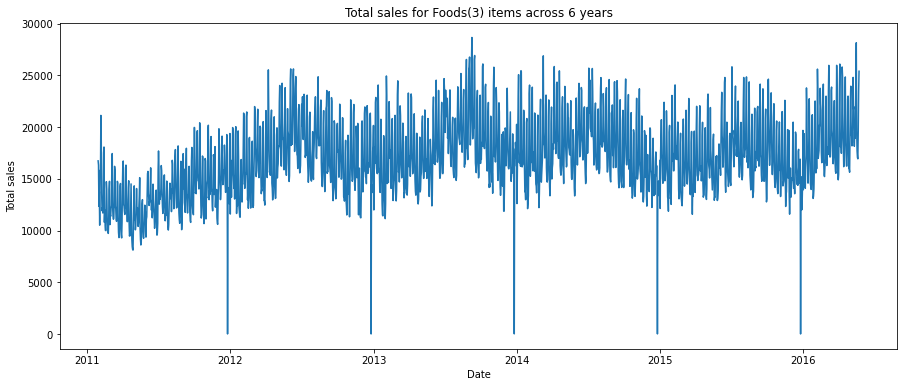

In [20]:
# Plot of total sales for foods_3 vs time 
plt.figure(figsize=(15,6))
plt.plot(df8.date, df8.FOODS_3)
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.title('Total sales for Foods(3) items across 6 years')

Text(0.5, 1.0, 'Total sales for Foods(3) items across 6 years')

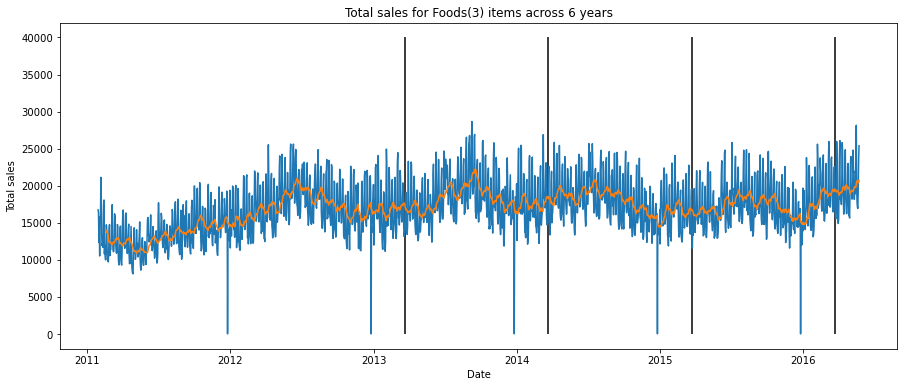

In [21]:
# Plot Rolling mean of total sales for foods_3 vs time 
rolling_mean = df8.FOODS_3.rolling(window=20).mean()

plt.figure(figsize=(15,6))
plt.plot(df8.date, df8.FOODS_3)
plt.vlines('2016-03-22',ymin=0, ymax=40000, color = 'k')
plt.vlines('2015-03-22',ymin=0, ymax=40000, color = 'k')
plt.vlines('2014-03-22',ymin=0, ymax=40000, color = 'k')
plt.vlines('2013-03-22',ymin=0, ymax=40000, color = 'k')

plt.plot(df8.date, rolling_mean)
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.title('Total sales for Foods(3) items across 6 years')

In [22]:
#Check FOODS_3 sales at yearly intervals on 22nd march 
print(df8[df8.date=='2013-03-22'])
print(df8[df8.date=='2014-03-22'])
print(df8[df8.date=='2015-03-22'])
print(df8[df8.date=='2016-03-22'])

          date  wday  month      d event_name_1 event_type_1  FOODS_3
783 2013-03-22     7      3  d_784          NaN          NaN    15376
           date  wday  month       d event_name_1 event_type_1  FOODS_3
1148 2014-03-22     1      3  d_1149          NaN          NaN    21055
           date  wday  month       d event_name_1 event_type_1  FOODS_3
1513 2015-03-22     2      3  d_1514          NaN          NaN    19579
           date  wday  month       d event_name_1 event_type_1  FOODS_3
1879 2016-03-22     4      3  d_1880          NaN          NaN    16552


There are sequential outliers in the data where the sales are 0 on certain days (perhaps closure days). Lets identify these:

In [23]:
df8[df8.FOODS_3 <= 5000]

,date,wday,month,d,event_name_1,event_type_1,FOODS_3
330,2011-12-25,2,12,d_331,Christmas,National,13
696,2012-12-25,4,12,d_697,Christmas,National,10
1061,2013-12-25,5,12,d_1062,Christmas,National,20
1426,2014-12-25,6,12,d_1427,Christmas,National,17
1791,2015-12-25,7,12,d_1792,Christmas,National,12


### Stationarity test: 

In [24]:
# Create dataframe with date index and FOODS_3 sales 
df9 = df8[[ 'date', 'FOODS_3']].set_index('date')
df9.head()

,FOODS_3
date,
2011-01-29,16741
2011-01-30,16333
2011-01-31,12343
2011-02-01,13764
2011-02-02,10525


In [25]:
# Augmented Dickey-Fuller test
df_adfuller = adfuller(df9, autolag = 'AIC')
print("Probability-Value: ", df_adfuller[1])

Probability-Value:  0.28258164090393967


### Apply arima model:

In [26]:
# Find the arima model with the lowest AIC 
auto_arima_fit = auto_arima(df9.FOODS_3, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=35624.606, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36638.865, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36635.369, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36629.980, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36636.869, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=35960.054, Time=1.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35830.491, Time=1.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=35470.146, Time=2.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=35862.717, Time=0.74 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=35065.666, Time=3.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=35606.096, Time=1.66 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=34899.541, Time=3.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=35279.334, Time=0.91 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=34886.258, Time=3.10 sec
 ARIMA(4,1,3)(0,0,0

In [27]:
# split the last 2 months as a test set 
train_data = df9.iloc[:-60]
test_data = df9.iloc[-60:]
print(df9.shape, train_data.shape, test_data.shape)

(1941, 1) (1881, 1) (60, 1)


In [28]:
#Set ARIMA function and fit model
model = ARIMA(train_data, order=(5,1,4))
result = model.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

In [29]:
# predict last two months of FOODS_3 sales
begin = len(train_data)
finish = len(train_data)+len(test_data)-1
prediction = result.predict(start = begin, end = finish, typ ='levels')
prediction.head()

2016-03-24    15636.099126
2016-03-25    17389.449965
2016-03-26    21844.660281
2016-03-27    22137.507289
2016-03-28    18124.396581
Freq: D, dtype: float64

Text(0.5, 1.0, 'Actual and predicted sales for Foods(3) items for March-May 2016')

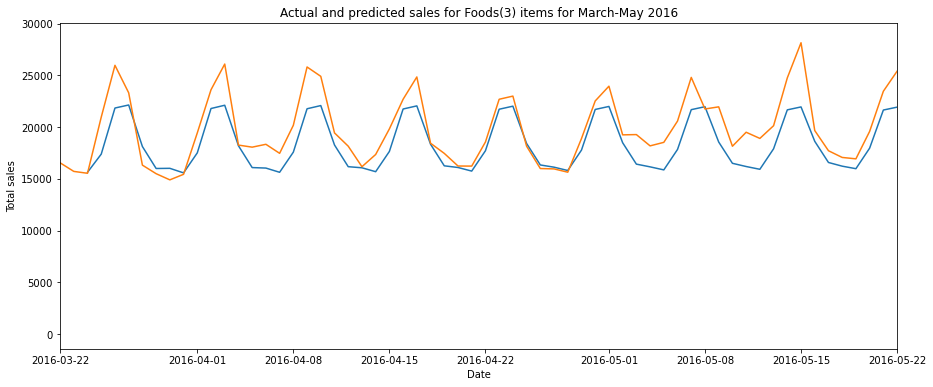

In [30]:
# Plot of total sales for foods_3 vs time 
plt.figure(figsize=(15,6))
plt.plot(prediction)
plt.plot(df9)
plt.xlim('2016-03-22', '2016-05-22')
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.title('Actual and predicted sales for Foods(3) items for March-May 2016')

In [31]:
#Compare FOODS_3 average sales with RMSE 
print("Average sales for foods(3) items is: ", test_data.FOODS_3.mean())
rmse = sqrt(mean_squared_error(test_data, prediction))
print("Root mean squared error is: ", rmse)

Average sales for foods(3) items is:  19936.15
Root mean squared error is:  2161.9705241159822


## Time-series forecasting using ML (instead of ARIMA): 

In [32]:
df8.head()

,date,wday,month,d,event_name_1,event_type_1,FOODS_3
0,2011-01-29,1,1,d_1,NaN,NaN,16741
1,2011-01-30,2,1,d_2,NaN,NaN,16333
2,2011-01-31,3,1,d_3,NaN,NaN,12343
3,2011-02-01,4,2,d_4,NaN,NaN,13764
4,2011-02-02,5,2,d_5,NaN,NaN,10525


In [33]:
#Locate NaN values 
df8.isnull().sum()

date               0
wday               0
month              0
d                  0
event_name_1    1783
event_type_1    1783
FOODS_3            0
dtype: int64

In [34]:
#Fill NaN's with 0 
df10 = df8.fillna(0)
df10.head()

,date,wday,month,d,event_name_1,event_type_1,FOODS_3
0,2011-01-29,1,1,d_1,0,0,16741
1,2011-01-30,2,1,d_2,0,0,16333
2,2011-01-31,3,1,d_3,0,0,12343
3,2011-02-01,4,2,d_4,0,0,13764
4,2011-02-02,5,2,d_5,0,0,10525


In [35]:
#Locate the special events
df10[df10.event_name_1 != 0]

,date,wday,month,d,event_name_1,event_type_1,FOODS_3
8,2011-02-06,2,2,d_9,SuperBowl,Sporting,18664
16,2011-02-14,3,2,d_17,ValentinesDay,Cultural,10801
23,2011-02-21,3,2,d_24,PresidentsDay,National,11405
39,2011-03-09,5,3,d_40,LentStart,Religious,11097
46,2011-03-16,5,3,d_47,LentWeek2,Religious,11096
...,...,...,...,...,...,...,...
1884,2016-03-27,2,3,d_1885,Easter,Cultural,23314
1918,2016-04-30,1,4,d_1919,Pesach End,Religious,22527
1919,2016-05-01,2,5,d_1920,OrthodoxEaster,Religious,23955
1923,2016-05-05,6,5,d_1924,Cinco De Mayo,Cultural,18528


In [36]:
#Create new dataframe with inputs and targets for ML modelling 
df11 = pd.DataFrame()
df11 = df10[['wday', 'month']]
df11['event'] = df10.event_type_1.replace({'Sporting': 1, 'Cultural':1, 'National':1, 'Religious':1})
df11['FOODS_3'] = df10.FOODS_3
df11.head()

<ipython-input-36-449c852cd933>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df11['event'] = df10.event_type_1.replace({'Sporting': 1, 'Cultural':1, 'National':1, 'Religious':1})
<ipython-input-36-449c852cd933>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df11['FOODS_3'] = df10.FOODS_3


,wday,month,event,FOODS_3
0,1,1,0,16741
1,2,1,0,16333
2,3,1,0,12343
3,4,2,0,13764
4,5,2,0,10525


In [37]:
#Check if events have been correctly altered to either 0 or 1 
df11.event.unique()

array([0, 1])

In [38]:
df11.shape

(1941, 4)

In [39]:
# split the last 2 months as a test set 
train_ML = df11.iloc[:-60]
test_ML = df11.iloc[-60:]
print(df11.shape, train_ML.shape, test_ML.shape)

(1941, 4) (1881, 4) (60, 4)


In [40]:
#Set the inputs and targets from train and test data 
train_input = train_ML.drop('FOODS_3', axis = 'columns')
train_target = train_ML.FOODS_3
test_input = test_ML.drop('FOODS_3', axis = 'columns')
test_target = test_ML.FOODS_3

print(train_input.shape, train_target.shape, test_input.shape, test_target.shape)

(1881, 3) (1881,) (60, 3) (60,)


In [41]:
#Define relevant sklearn ML models 
linear = LinearRegression()
forest = RandomForestClassifier()
gauss = GaussianNB()

In [42]:
#Linear Regression fitting and prediction 
linear.fit(train_input, train_target)
y_predicted_linear = linear.predict(test_input)
linear.score(test_input, test_target)

-0.47581028274262427

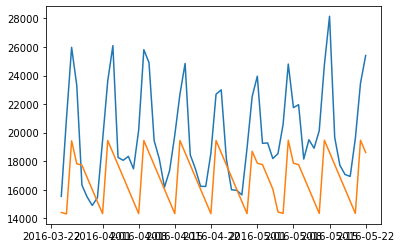

In [43]:
# Plot the predicted and actual last two months of sales 
test_date = df10.date.iloc[-60:]
plt.plot(test_date, test_target)
plt.plot(test_date, y_predicted_linear)

In [44]:
#Random forest fitting and prediction 
forest.fit(train_input, train_target)
y_predicted_forest = forest.predict(test_input)
forest.score(test_input, test_target)

0.0

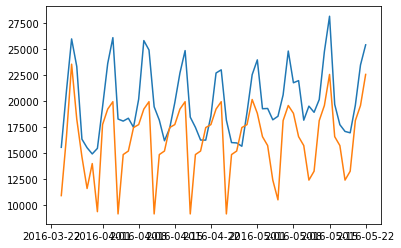

In [45]:
# Plot the predicted and actual last two months of sales 
plt.plot(test_date, test_target)
plt.plot(test_date, y_predicted_forest)

In [46]:
#GaussianNB fitting and prediction 
gauss.fit(train_input, train_target)
y_predicted_gauss = gauss.predict(test_input)
gauss.score(test_input, test_target)

0.0

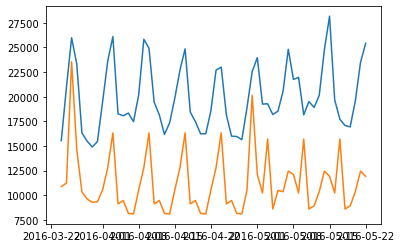

In [47]:
# Plot the predicted and actual last two months of sales 
plt.plot(test_date, test_target)
plt.plot(test_date, y_predicted_gauss)

### Lets add more features to the models - week of the month, week of the year? 

In [48]:
# re-visit complete dataframe for FOODS_3
df10.head()

,date,wday,month,d,event_name_1,event_type_1,FOODS_3
0,2011-01-29,1,1,d_1,0,0,16741
1,2011-01-30,2,1,d_2,0,0,16333
2,2011-01-31,3,1,d_3,0,0,12343
3,2011-02-01,4,2,d_4,0,0,13764
4,2011-02-02,5,2,d_5,0,0,10525


In [49]:
#Create dataframe with the week of the year for each date in date column 
df12 = pd.DataFrame()
df12['week_of_year'] = np.arange(len(df10))

for i in range(0, len(df10)): 
    df12.week_of_year[i] = df10.date[i].isocalendar()[1]
df12

,week_of_year
0,4
1,4
2,5
3,5
4,5
...,...
1936,20
1937,20
1938,20
1939,20


In [50]:
len(df12)

1941

In [51]:
#Create new dataframe with additional feature for ML modelling 
df13 = df11.copy()
df13['week_of_year'] = df12.week_of_year
df13.head()

,wday,month,event,FOODS_3,week_of_year
0,1,1,0,16741,4
1,2,1,0,16333,4
2,3,1,0,12343,5
3,4,2,0,13764,5
4,5,2,0,10525,5


In [52]:
# split the last 2 months as a test set 
train_ML2 = df13.iloc[:-60]
test_ML2 = df13.iloc[-60:]
print(df13.shape, train_ML2.shape, test_ML2.shape)

(1941, 5) (1881, 5) (60, 5)


In [53]:
#Set the inputs and targets from train and test data 
train_input2 = train_ML2.drop('FOODS_3', axis = 'columns')
train_target2 = train_ML2.FOODS_3
test_input2 = test_ML2.drop('FOODS_3', axis = 'columns')
test_target2 = test_ML2.FOODS_3

print(train_input2.shape, train_target2.shape, test_input2.shape, test_target2.shape)

(1881, 4) (1881,) (60, 4) (60,)


In [54]:
#Linear Regression fitting and prediction 
linear.fit(train_input2, train_target2)
y_predicted_linear2 = linear.predict(test_input2)
linear.score(test_input2, test_target2)

-0.40757095142686106

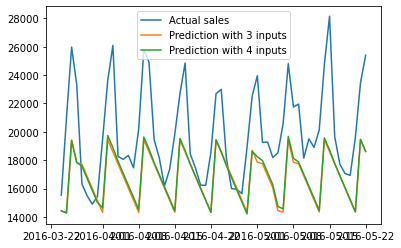

In [55]:
# Plot the predicted and actual last two months of sales 
test_date = df10.date.iloc[-60:]
plt.plot(test_date, test_target2, label='Actual sales')
plt.plot(test_date, y_predicted_linear, label='Prediction with 3 inputs')
plt.plot(test_date, y_predicted_linear2, label='Prediction with 4 inputs')
plt.legend()

In [56]:
#Random forest fitting and prediction 
forest.fit(train_input2, train_target2)
y_predicted_forest2 = forest.predict(test_input2)
forest.score(test_input2, test_target2)

0.0

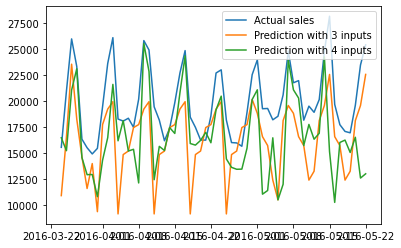

In [57]:
# Plot the predicted and actual last two months of sales 
plt.plot(test_date, test_target2, label='Actual sales')
plt.plot(test_date, y_predicted_forest, label='Prediction with 3 inputs')
plt.plot(test_date, y_predicted_forest2, label='Prediction with 4 inputs')
plt.legend()

In [58]:
#GaussianNB fitting and prediction 
gauss.fit(train_input2, train_target2)
y_predicted_gauss2 = gauss.predict(test_input2)
gauss.score(test_input2, test_target2)

0.0

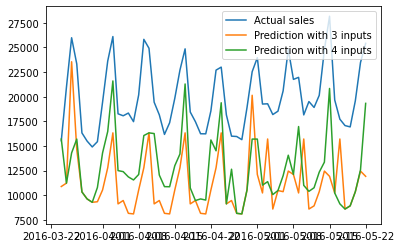

In [59]:
# Plot the predicted and actual last two months of sales 
plt.plot(test_date, test_target, label='Actual sales')
plt.plot(test_date, y_predicted_gauss, label='Prediction with 3 inputs')
plt.plot(test_date, y_predicted_gauss2, label='Prediction with 4 inputs')
plt.legend()

In [60]:
df10.date.dt.isocalendar().week

0        4
1        4
2        5
3        5
4        5
        ..
1936    20
1937    20
1938    20
1939    20
1940    20
Name: week, Length: 1941, dtype: UInt32

In [61]:
df_123 = df10.date.dt.isocalendar()

### Using exponential smoothing to find trend in FOODS_3

In [62]:
# Use the same dataframe as the Arima model (time vs sales)
df9.head()

,FOODS_3
date,
2011-01-29,16741
2011-01-30,16333
2011-01-31,12343
2011-02-01,13764
2011-02-02,10525


In [63]:
#Do Exp Smoothing fit with 3 types of smoothing levels 
Smoothing_fit1 = SimpleExpSmoothing(df9).fit(smoothing_level = 0.25, optimized = False)
Smoothing_fit2 = SimpleExpSmoothing(df9).fit(smoothing_level = 0.5, optimized = False)
Smoothing_fit3 = SimpleExpSmoothing(df9).fit(smoothing_level = 0.75, optimized = False)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'Actual and predicted sales for Foods(3) items for March-May 2016')

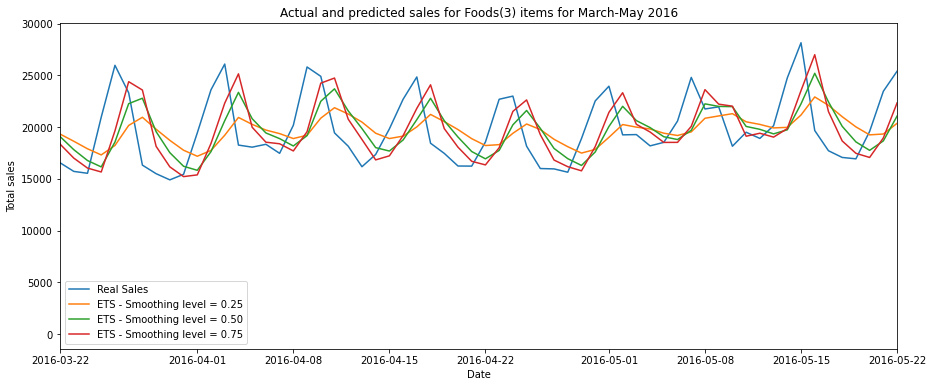

In [64]:
# Plot of total sales for foods_3 vs time 
plt.figure(figsize=(15,6))
plt.plot(df9, label = 'Real Sales')
# plt.plot(prediction, label = 'ARIMA')
plt.plot(Smoothing_fit1.fittedvalues, label = 'ETS - Smoothing level = 0.25')
plt.plot(Smoothing_fit2.fittedvalues, label = 'ETS - Smoothing level = 0.50')
plt.plot(Smoothing_fit3.fittedvalues, label = 'ETS - Smoothing level = 0.75')
plt.legend()
plt.xlim('2016-03-22', '2016-05-22')
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.title('Actual and predicted sales for Foods(3) items for March-May 2016')

### Lets take Smoothing level = 0.75 as the "best" fit. We need to add this as a feature to our ML models and see if it improvee.

In [65]:
#Reset index of smoothing fit so that we can drop the date column
df14 = pd.DataFrame()
df14 = Smoothing_fit3.fittedvalues.reset_index()
df14[0]

0       16741.000000
1       16741.000000
2       16435.000000
3       13366.000000
4       13664.500000
            ...     
1936    18663.607411
1937    17467.651853
1938    17068.162963
1939    18956.540741
1940    22337.135185
Name: 0, Length: 1941, dtype: float64

In [66]:
#Add Exp-smoothing fit3 to df13 as an input feature
df15 = df13.copy()
df15['Exp_smoothing'] = df14[0] 
df15.head(5)

,wday,month,event,FOODS_3,week_of_year,Exp_smoothing
0,1,1,0,16741,4,16741.0
1,2,1,0,16333,4,16741.0
2,3,1,0,12343,5,16435.0
3,4,2,0,13764,5,13366.0
4,5,2,0,10525,5,13664.5


In [67]:
len(df15)

1941

In [68]:
# split the last 2 months as a test set 
train_ML3 = df15.iloc[:-60]
test_ML3 = df15.iloc[-60:]
print(df15.shape, train_ML3.shape, test_ML3.shape)

(1941, 6) (1881, 6) (60, 6)


In [69]:
test_ML3

,wday,month,event,FOODS_3,week_of_year,Exp_smoothing
1881,6,3,1,15539,12,16040.827174
1882,7,3,0,20964,12,15664.456794
1883,1,3,0,25972,12,19639.114198
1884,2,3,1,23314,12,24388.778550
1885,3,3,0,16326,13,23582.694637
1886,4,3,0,15499,13,18140.173659
1887,5,3,0,14903,13,16159.293415
1888,6,3,0,15439,13,15217.073354
1889,7,4,0,19440,13,15383.518338
1890,1,4,0,23610,13,18425.879585


In [70]:
#Set the inputs and targets from train and test data 
train_input3 = train_ML3.drop('FOODS_3', axis = 'columns')
train_target3 = train_ML3.FOODS_3
test_input3 = test_ML3.drop('FOODS_3', axis = 'columns')
test_target3 = test_ML3.FOODS_3

print(train_input3.shape, train_target3.shape, test_input3.shape, test_target3.shape)

(1881, 5) (1881,) (60, 5) (60,)


In [71]:
#Linear Regression fitting and prediction 
linear.fit(train_input3, train_target3)
y_predicted_linear3 = linear.predict(test_input3)
linear.score(test_input3, test_target3)

0.073750221815995

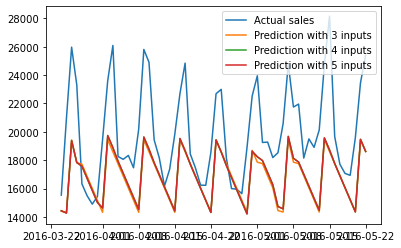

In [72]:
# Plot the predicted and actual last two months of sales 
test_date = df10.date.iloc[-60:]
plt.plot(test_date, test_target3, label='Actual sales')
plt.plot(test_date, y_predicted_linear, label='Prediction with 3 inputs')
plt.plot(test_date, y_predicted_linear2, label='Prediction with 4 inputs')
plt.plot(test_date, y_predicted_linear2, label='Prediction with 5 inputs')
plt.legend()

In [73]:
#Random forest fitting and prediction 
forest.fit(train_input3, train_target3)
y_predicted_forest3 = forest.predict(test_input3)
forest.score(test_input3, test_target3)

0.0

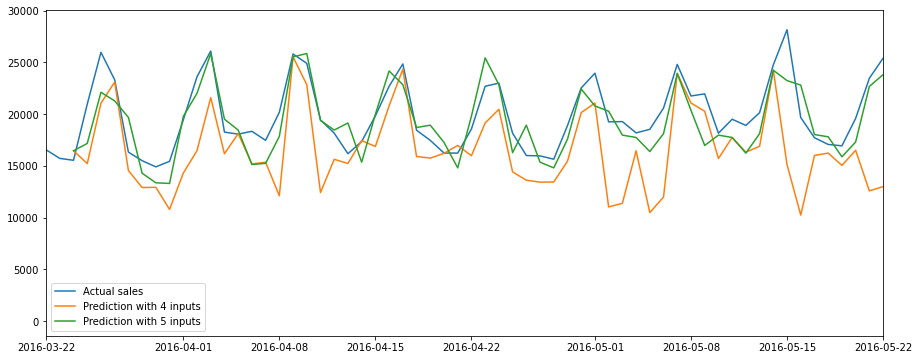

In [74]:
# Plot the predicted and actual last two months of sales 
test_date = df10.date.iloc[-60:]
plt.figure(figsize=(15,6))
plt.plot(df8.date, df8.FOODS_3, label='Actual sales')
#plt.plot(test_date, y_predicted_forest, label='Prediction with 3 inputs')
plt.plot(test_date, y_predicted_forest2, label='Prediction with 4 inputs')
plt.plot(test_date, y_predicted_forest3, label='Prediction with 5 inputs')
plt.xlim('2016-03-22', '2016-05-22')
plt.legend()

In [75]:
#GaussianNB fitting and prediction 
gauss.fit(train_input3, train_target3)
y_predicted_gauss3 = gauss.predict(test_input3)
gauss.score(test_input3, test_target3)

0.0

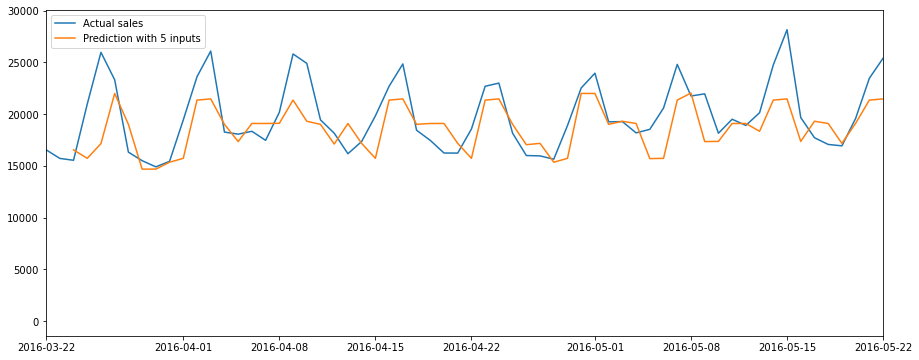

In [76]:
# Plot the predicted and actual last two months of sales 
plt.figure(figsize=(15,6))
plt.plot(df8.date, df8.FOODS_3, label='Actual sales')
#plt.plot(test_date, y_predicted_gauss, label='Prediction with 3 inputs')
#plt.plot(test_date, y_predicted_gauss2, label='Prediction with 4 inputs')
plt.plot(test_date, y_predicted_gauss3, label='Prediction with 5 inputs')
plt.xlim('2016-03-22', '2016-05-22')
plt.legend()

### ---------------------------------------------------------

### TEST MODEL ON HOUSEHOLD_1 ITEMS 

In [77]:
df16 = df1[df1.dept_id == 'HOUSEHOLD_1']
df16.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
565,HOUSEHOLD_1_001_CA_1_evaluation,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,3,0,0,0,...,2,0,1,1,0,0,0,0,1,2
566,HOUSEHOLD_1_002_CA_1_evaluation,HOUSEHOLD_1_002,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,1,2,4,...,0,1,0,1,1,1,0,0,2,1
567,HOUSEHOLD_1_003_CA_1_evaluation,HOUSEHOLD_1_003,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,0,0,0,0,...,0,1,1,1,0,0,0,0,2,1
568,HOUSEHOLD_1_004_CA_1_evaluation,HOUSEHOLD_1_004,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,4,0,8,11,...,4,0,4,0,2,0,1,7,7,2
569,HOUSEHOLD_1_005_CA_1_evaluation,HOUSEHOLD_1_005,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,0,3,2,2,...,1,1,0,0,0,1,0,1,1,4


In [78]:
df17 = df16.drop(['id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis = 'columns')
df17.head()

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
565,HOUSEHOLD_1_001,3,0,0,0,0,0,0,1,0,...,2,0,1,1,0,0,0,0,1,2
566,HOUSEHOLD_1_002,1,1,2,4,1,0,0,1,0,...,0,1,0,1,1,1,0,0,2,1
567,HOUSEHOLD_1_003,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,2,1
568,HOUSEHOLD_1_004,4,0,8,11,1,0,3,8,6,...,4,0,4,0,2,0,1,7,7,2
569,HOUSEHOLD_1_005,0,3,2,2,1,2,1,1,0,...,1,1,0,0,0,1,0,1,1,4


In [79]:
#Aggregate the items from all the Walmart stores as singular total sales per item
df18 = df17.groupby('item_id').sum()
df18.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
HOUSEHOLD_1_001,7,3,2,2,1,4,3,6,1,1,...,7,1,9,6,2,2,7,5,6,8
HOUSEHOLD_1_002,8,7,5,10,4,1,6,12,7,3,...,3,13,9,4,3,6,7,3,13,11
HOUSEHOLD_1_003,0,0,0,0,0,0,0,0,0,0,...,7,6,12,2,1,5,4,7,7,7
HOUSEHOLD_1_004,26,25,28,29,9,16,18,27,25,33,...,23,20,30,21,15,16,13,25,23,24
HOUSEHOLD_1_005,11,14,7,7,4,15,6,12,11,9,...,15,16,21,14,8,7,7,18,13,20


In [80]:
# Get total sales per day for HOUSEHOLD_1 items 
df19 = pd.DataFrame()
df19['HOUSEHOLD_1'] = df18.sum()
df19.reset_index(inplace=True)
df19.head()

,index,HOUSEHOLD_1
0,d_1,4105
1,d_2,3858
2,d_3,2827
3,d_4,2732
4,d_5,1802


In [81]:
df19.shape

(1941, 2)

In [82]:
df20 = df15.drop(['FOODS_3', 'Exp_smoothing'], axis = 'columns')
df20['HOUSEHOLD_1'] = df19.HOUSEHOLD_1
df20.head()

,wday,month,event,week_of_year,HOUSEHOLD_1
0,1,1,0,4,4105
1,2,1,0,4,3858
2,3,1,0,5,2827
3,4,2,0,5,2732
4,5,2,0,5,1802


In [83]:
#Do Exp Smoothing fit 
df21 = pd.DataFrame()
df21 = df9.copy().reset_index()
df21['HOUSEHOLD_1'] = df20.HOUSEHOLD_1
df22 = df21.drop('FOODS_3', axis = 'columns').set_index('date')
Smoothing_fit4 = SimpleExpSmoothing(df22).fit(smoothing_level = 0.75, optimized = False)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [84]:
df22.head()

,HOUSEHOLD_1
date,
2011-01-29,4105
2011-01-30,3858
2011-01-31,2827
2011-02-01,2732
2011-02-02,1802


In [85]:
# Plot of total sales for household_1 vs time 
#plt.figure(figsize=(15,6))
#plt.plot(df22)
#plt.xlabel('Date')
#plt.ylabel('Total sales')
#plt.title('Total sales for Household(1) items across 6 years')


Text(0.5, 1.0, 'Actual and predicted sales for Foods(3) items for March-May 2016')

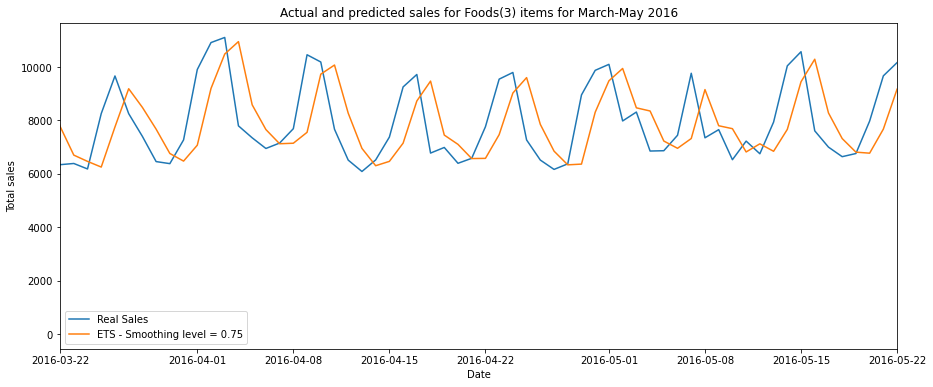

In [86]:
# Plot of total sales for household_1 vs time for last two months
plt.figure(figsize=(15,6))
plt.plot(df22, label = 'Real Sales')
plt.plot(Smoothing_fit4.fittedvalues, label = 'ETS - Smoothing level = 0.75')
plt.legend()
plt.xlim('2016-03-22', '2016-05-22')
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.title('Actual and predicted sales for Foods(3) items for March-May 2016')

In [87]:
#Reset index of smoothing fit so that we can drop the date column
df22 = pd.DataFrame()
df22 = Smoothing_fit4.fittedvalues.reset_index()
df22[0]

0       4105.000000
1       4105.000000
2       3919.750000
3       3100.187500
4       2824.046875
           ...     
1936    7319.112406
1937    6810.528101
1938    6771.882025
1939    7673.470506
1940    9169.367627
Name: 0, Length: 1941, dtype: float64

In [88]:
#Add Exp-smoothing fit4 to df20 as an input feature
df20['Exp_smoothing'] = df22[0] 
df20.head(5)

,wday,month,event,week_of_year,HOUSEHOLD_1,Exp_smoothing
0,1,1,0,4,4105,4105.000000
1,2,1,0,4,3858,4105.000000
2,3,1,0,5,2827,3919.750000
3,4,2,0,5,2732,3100.187500
4,5,2,0,5,1802,2824.046875


In [89]:
# split the last 2 months as a test set 
train_ML4 = df20.iloc[:-60]
test_ML4 = df20.iloc[-60:]
print(df20.shape, train_ML4.shape, test_ML4.shape)

(1941, 6) (1881, 6) (60, 6)


In [90]:
#Set the inputs and targets from train and test data 
train_input4 = train_ML4.drop('HOUSEHOLD_1', axis = 'columns')
train_target4 = train_ML4.HOUSEHOLD_1
test_input4 = test_ML4.drop('HOUSEHOLD_1', axis = 'columns')
test_target4 = test_ML4.HOUSEHOLD_1

print(train_input4.shape, train_target4.shape, test_input4.shape, test_target4.shape)

(1881, 5) (1881,) (60, 5) (60,)


In [91]:
# Random forest fitting and prediction 
forest.fit(train_input4, train_target4)
y_predicted_forest4 = forest.predict(test_input4)
forest.score(test_input4, test_target4)

0.0

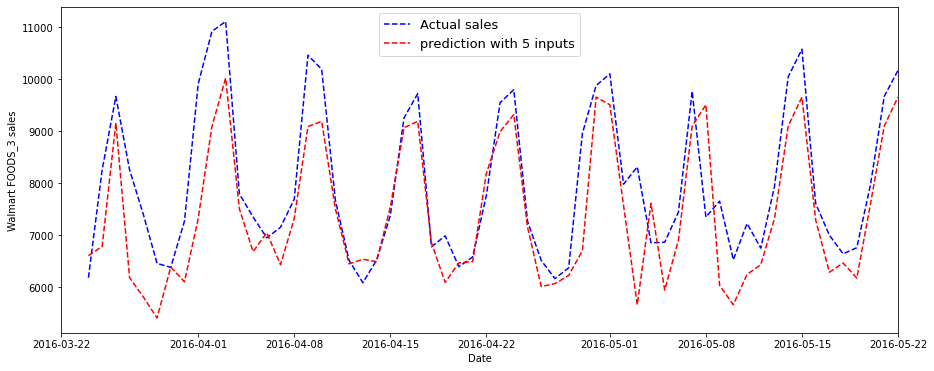

In [107]:
# Plot the predicted and actual last two months of sales 
test_date = df10.date.iloc[-60:]
plt.figure(figsize=(15,6))
plt.plot(test_date, test_target4, 'b--', label='Actual sales',)
plt.plot(test_date, y_predicted_forest4,'r--', label='prediction with 5 inputs')
plt.xlim('2016-03-22', '2016-05-22')
plt.xlabel('Date')
plt.ylabel('Walmart FOODS_3 sales')
plt.legend(prop={'size': 13})

In [173]:
modelETS = ETSModel(df25[0].iloc[:-60], error="add", trend="add", seasonal="add",
                damped_trend=False, seasonal_periods=7)
fit = modelETS.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [175]:
x = fit.predict(start='2016-01-24', end='2016-05-24')
x.unique()

array([ 8664.7494006 ,  9153.04697051,  7974.95596906,  7059.2722996 ,
        6508.40270682,  6476.60465411,  6581.77545373,  9223.58684553,
        9683.21353778,  8544.59740306,  8146.14745201,  7642.05849741,
        7739.72266708,  7686.50176279,  9861.49158509,  9857.91597396,
        7907.18532385,  6583.03885866,  6597.81597047,  6997.37818593,
        7742.64685257, 10079.37767267, 10052.38329922,  8271.5820313 ,
        7635.64620422,  7492.52221619,  7376.86754207,  7512.08452361,
        9816.61224374,  9833.24060436,  8916.35691444,  7639.36823681,
        7385.75033586,  7316.97423374,  7496.41036425,  9563.39739768,
        9426.74967199,  8396.99133882,  7399.86304004,  7584.10422142,
        7759.44992234,  8261.38004041, 10221.27643894, 10080.35066895,
        8889.89444345,  7710.5219008 ,  7274.22072826,  7126.07075442,
        7306.01546045,  9448.2283727 ,  9961.408556  ,  8366.5942341 ,
        7326.73514054,  7213.80833557,  7253.74430401,  7202.42390711,
      

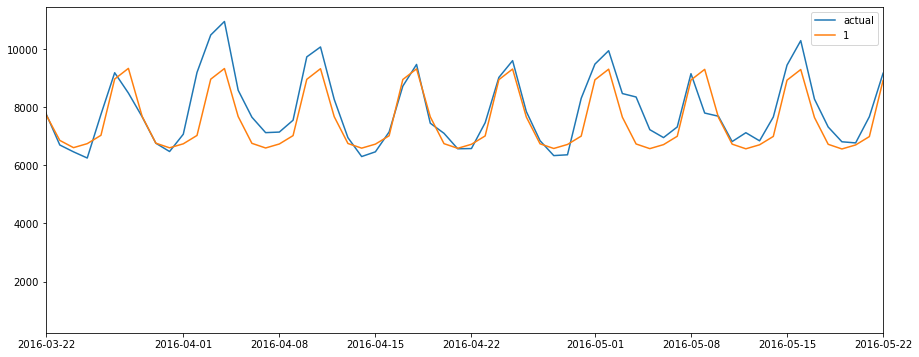

In [177]:
plt.figure(figsize=(15,6))
plt.plot(df25, label = 'actual')
plt.plot(x, label='1')
#plt.plot(SES_predict2, label='2')
plt.xlim('2016-03-22', '2016-05-22')
plt.legend()